In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [2]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [23]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [24]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'{target_column}/{city}.csv',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [25]:
for city, state, conties in cities:
    df0 = pd.read_csv(f'S000/{city}.csv')
    df1 = pd.read_csv(f'SE01/{city}.csv')
    df3 = pd.read_csv(f'SE03/{city}.csv')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_csv(f'income/{city}.csv', index=False)

# baseline

### unconstrain model, power law

In [4]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [43]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    print(binf,k)
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [50]:
def unconstrained_linear_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values*data['distance'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData['distance']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    print(binf,k)
    return (binf,k)
def unconstrained_linear_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test['distance']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [20]:
minValue = []
maxValue = []
for city, state, conties in cities:
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
#     df = pd.to_csv(f'income/{city}.csv',index=)
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-2.5900184418179637 4.73316276832494


In [51]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [52]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.01*len(df)),2000)
    thre = int(rate*len(df))


    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [53]:


# 5-fold 
resultsfd40is = {}
resultsfd40os = {}

resultslfd40is = {}
resultslfd40os = {}

resultsBaselineis = {}
resultsBaselineos = {}
number = 2000
fdworsecounttemp = 0
rate = 0.002
bins = 40
for city,state, counties in cities[4:]:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    binlist = []
    longestbin = []
    for binInd in sorted(df.bin.unique()):
        ODvolume = len(df.loc[df['bin']==binInd])
    #     print(ODvolume)
        if ODvolume > 200:
            binlist += [binInd]
        else:
            if len(binlist) > len(longestbin):
                longestbin = binlist
    #         print(binlist)
            binlist = []
    # when all bin statisfy 0.1%, longestbin will be empty    
    if len(binlist) > len(longestbin):
        selectedbin = binlist
    else:
        selectedbin = longestbin
    df = df.loc[df['bin'].isin(selectedbin)]
    
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
        # fd
    for target in ['SE01','SE03','S000']:
        print(target)

        fdmseis = 0
        fdmseos = 0
        lfdmseis = 0
        lfdmseos = 0
        blmseis = 0
        blmseos = 0
        for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
            traindf, testdf = df.iloc[train_index], df.iloc[test_index]
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            
            # linear f(d), include distance in formulation
            binf,k = unconstrained_linear_bucked_constant_kfit(traindf, target)
            df_lfdis = unconstrained_linear_bucked_constant_kpredict(traindf,target,k,binf)
            df_lfdos = unconstrained_linear_bucked_constant_kpredict(testdf,target,k,binf)
            
            fdmseis += mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos += mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
            
            lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
            lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])
        
            # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
        
            
        resultsfd40is[city] = resultsfd40is.get(city,[])+ [fdmseis/5]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ [fdmseos/5,]
        
        resultslfd40is[city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
        resultslfd40os[city] = resultslfd40os.get(city,[])+ [lfdmseos/5]
        
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + [blmseis/5]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + [blmseos/5]
        print('---------------------------------------')
        print('os',round(blmseos/5,2),fdmseos,lfdmseos)
        if fdmseos > blmseos:
            fdworsecounttemp += 1


Boston
SE01
{0: 5.73723729526867, 1: 7.251913448803858, 2: 7.5160051984763125, 3: 5.275395448923123, 4: 5.3710751697670975, 5: 4.101663714696552, 6: 4.0805524456092925, 7: 4.461099253616349, 8: 3.919167848693464, 9: 2.674046017520084, 10: 2.891147270517387, 11: 3.07646898686526, 12: 2.4336742262656226, 13: 2.365722800528977, 14: 1.9174257546016913, 15: 1.860580105405848, 16: 1.5461901440060744, 17: 1.482657030450612, 18: 1.4086332900051575, 19: 1.3699890846027174, 20: 1.272684458064618, 21: 1.132266764766542, 22: 1.076541997003312, 23: 0.9098531567156605, 24: 0.8415124803079321, 25: 0.7588365169202045, 26: 0.6959444158302451, 27: 0.6552611498010248, 28: 0.5871065306594232, 29: 0.5045179904403426, 30: 0.42874107420885366, 31: 0.362185645866778, 32: 0.3076655880504717, 33: 0.27592366926655676, 34: 0.25452273962994787, 35: 0.23621959693897676, 36: 0.24919637575785758, 37: 0.27769166161619757, 38: 0.07992353227566404, 39: 0.30000978450491134} 5.855570930352864e-06
{0: 292.05722395485896, 1

{0: 293.06221784538326, 1: 317.0547441785547, 2: 309.44057169460996, 3: 192.61177943881222, 4: 177.0109236714071, 5: 115.14112917766151, 6: 101.92414103529097, 7: 103.99607262917539, 8: 91.7715748971841, 9: 52.798661242194534, 10: 56.587040965057405, 11: 50.835587823953226, 12: 35.13961346662413, 13: 28.78458003246112, 14: 21.444975942108705, 15: 17.5401680484261, 16: 12.853225807272462, 17: 11.359910335320507, 18: 10.243637254552805, 19: 8.958859020567154, 20: 6.993158119633385, 21: 5.478131924591641, 22: 4.591237681820182, 23: 3.441742754863043, 24: 2.9248457968883304, 25: 2.326824269183441, 26: 1.848286975962784, 27: 1.6183409418008177, 28: 1.2822551849905761, 29: 0.9574376452120468, 30: 0.8070201445117758, 31: 0.5575530221008431, 32: 0.4222701668099837, 33: 0.3556691977271509, 34: 0.2767640139499682, 35: 0.2345277728350126, 36: 0.21654589424563198, 37: 0.1556826327694683, 38: 0.05551088475646014, 39: 0.2067409358841459} 2.060438472636551e-07
---------------------------------------


{0: 2.8934880873537248, 1: 2.8642645739302326, 2: 2.5605601078872873, 3: 2.448360893594878, 4: 2.4183292378331975, 5: 2.305865012092157, 6: 2.400282112340949, 7: 2.261191988874586, 8: 1.9155627703176918, 9: 2.0431173020065314, 10: 1.7657248612925487, 11: 1.9872371221404441, 12: 1.6588131116344353, 13: 1.5825574350664189, 14: 1.3831763844492064, 15: 1.3142029068395948, 16: 1.2559052731501779, 17: 1.3097730676733703, 18: 1.2883012769182878, 19: 1.2532083084719814, 20: 1.1575685452294413, 21: 1.086099262952028, 22: 1.0579480735232092, 23: 0.9665140507096184, 24: 0.9264400689044819, 25: 0.8564485268076802, 26: 0.7836612436673506, 27: 0.7167781284347432, 28: 0.7619166109782624, 29: 0.6526604069970545, 30: 0.6554161106086855, 31: 0.597351306397806, 32: 0.5061818094476707, 33: 0.3786944601078005, 34: 0.38346824881478503, 35: 0.3163124172510836, 36: 0.34635242579244446, 37: 0.37010480282153513, 38: 0.32272689645629926, 39: 0.17283902071014667} 1.700581804318868e-06
{0: 118.94032634390757, 1: 1

{0: 143.48061992902598, 1: 129.60187620475608, 2: 134.60788119537634, 3: 103.48126526946874, 4: 83.1019996691433, 5: 68.28828574432296, 6: 63.667789921818326, 7: 55.01233249639557, 8: 39.73447178859554, 9: 38.42198951106259, 10: 28.94705429994942, 11: 26.506322238227394, 12: 19.969665908441172, 13: 17.017423213063125, 14: 13.479582744625462, 15: 11.7095963551541, 16: 9.349979085932215, 17: 8.528473013908677, 18: 7.126038180763254, 19: 6.244151704888702, 20: 5.32560550848984, 21: 4.505503961061493, 22: 3.8409376762757224, 23: 3.1815327359847734, 24: 2.647358254504611, 25: 2.181149804879237, 26: 1.8432107758301781, 27: 1.50199476723156, 28: 1.3515550823957103, 29: 1.0456912302755828, 30: 0.8094463092026313, 31: 0.6668926026652842, 32: 0.5060454435327189, 33: 0.32706148347696634, 34: 0.30990250831170596, 35: 0.26896229549077444, 36: 0.24119403067220108, 37: 0.19116852206921256, 38: 0.1549666911685372, 39: 0.1224471436954857} 4.2977706672530364e-08
{0: 3.3183643847511504, 1: 3.340706541428

{3: 7.304827517721726, 4: 7.299412564314845, 5: 6.927547508917159, 6: 4.255173245220205, 7: 4.471217142397359, 8: 3.9784509682245757, 9: 4.039699179346069, 10: 4.901188257095006, 11: 3.6979843404492088, 12: 3.4345171892984485, 13: 2.8327368812444003, 14: 3.4205407402509365, 15: 2.6903127055225315, 16: 2.3549058838215524, 17: 2.410345619679292, 18: 2.020161900800095, 19: 1.9070525618172625, 20: 1.8217163958535636, 21: 1.696885634093202, 22: 1.4872137001658838, 23: 1.4496145014055954, 24: 1.4027491624315847, 25: 1.255974374215727, 26: 1.1964212613480474, 27: 1.0332114084196258, 28: 0.8737844927025716, 29: 0.8101370396141843, 30: 0.7391350697585027, 31: 0.6683772143518003, 32: 0.5815315779829893, 33: 0.540594845554963, 34: 0.5037416106788182, 35: 0.48528906515820713, 36: 0.4205499675145271, 37: 0.4092406317229197, 38: 0.43226338203532544, 39: 0.4243498264796008} 2.9765413786305586e-06
{3: 255.36562194535824, 4: 255.10766257225015, 5: 223.55881677415454, 6: 126.64073367709778, 7: 112.36690

{3: 4.6492709533760515, 4: 4.648920137009743, 5: 4.415206216154253, 6: 4.101248121057134, 7: 3.5321725221095663, 8: 3.6116495185896675, 9: 3.730216182151149, 10: 3.2995625145674587, 11: 3.1910185338751758, 12: 3.12893402732318, 13: 2.4665534511827176, 14: 2.647211184501537, 15: 2.456930513524394, 16: 2.2982877390457612, 17: 2.316860462871486, 18: 2.0003723664029014, 19: 1.9246159761630877, 20: 1.850547019555284, 21: 1.7307632452427537, 22: 1.6421047367844053, 23: 1.5346467834581823, 24: 1.475420909546473, 25: 1.3496336518907124, 26: 1.3000749988796745, 27: 1.138781430643732, 28: 1.0570708370504858, 29: 0.9681498603954526, 30: 0.8802872239699603, 31: 0.828610586883199, 32: 0.7476898374351895, 33: 0.6305647506670535, 34: 0.540208876626461, 35: 0.49605598037051823, 36: 0.4186957105705237, 37: 0.3378664708664799, 38: 0.375588151832076, 39: 0.34748219554558024} 1.245054374350094e-06
{3: 144.63959111057164, 4: 144.62563832551365, 5: 129.3105810341549, 6: 111.76804422166681, 7: 81.40531495849

{3: 5.4901898426250835, 4: 5.488819727063603, 5: 5.239209391519038, 6: 4.149598612881366, 7: 3.4168809339167523, 8: 3.4412250394391757, 9: 3.777375443091055, 10: 3.7993153173043996, 11: 3.071631050304492, 12: 3.2072092463405326, 13: 2.5705871947757974, 14: 2.8560153948641305, 15: 2.4249460904334406, 16: 2.193231498257481, 17: 2.2226389604486227, 18: 1.9566652340508188, 19: 1.8307443961079664, 20: 1.7312433289603948, 21: 1.6603857405508928, 22: 1.5341523306860712, 23: 1.4456795481334919, 24: 1.3871048403270232, 25: 1.2924214633277813, 26: 1.2329328887942084, 27: 1.082556271266853, 28: 0.9708204427918679, 29: 0.8919254821009578, 30: 0.7982464302684698, 31: 0.7575615429980593, 32: 0.6864915151525743, 33: 0.5966496054847461, 34: 0.530261503877166, 35: 0.4923941947936209, 36: 0.4388691629777162, 37: 0.3833993859892709, 38: 0.4221437073576473, 39: 0.3658880523919074} 5.792090374471984e-07
{3: 174.55679439412413, 4: 174.49904918027005, 5: 156.13867301490598, 6: 112.74682296548235, 7: 78.79976

{0: 3.54611453169675, 1: 3.001205452230448, 2: 3.240027470316237, 3: 2.3714706933929595, 4: 3.273442553219896, 5: 2.5269385658205907, 6: 2.232600842739304, 7: 1.6429214356440727, 8: 2.2842379478650257, 9: 1.4363110494133913, 10: 1.349122564893991, 11: 1.4706137732990125, 12: 1.4081506922402385, 13: 1.1498620113869578, 14: 1.2711011720502032, 15: 1.1633346243684857, 16: 1.1123967577659828, 17: 1.0526793154069123, 18: 1.047743048756005, 19: 0.9153995393458785, 20: 0.8474758739990168, 21: 0.89900756377256, 22: 0.8471800711697819, 23: 0.869692421142084, 24: 0.7284341650296822, 25: 0.6254746484385492, 26: 0.5869283779496367, 27: 0.5204424834776583, 28: 0.4948697224587842, 29: 0.4466496815904575, 30: 0.3870711975328249, 31: 0.30567390244107173} 1.1832175354055022e-05
{0: 65.68749193049209, 1: 49.6188968999135, 2: 47.82311961574521, 3: 30.468910271753472, 4: 37.84704378500975, 5: 26.128264780547337, 6: 20.315103607495185, 7: 13.191826350520385, 8: 16.710556633162668, 9: 9.459276572569282, 10:

{0: 1.618086644850563, 1: 1.3954036982100457, 2: 2.679427937286158, 3: 1.7703038243064335, 4: 1.273925148985253, 5: 1.5390728908782887, 6: 1.4328533617056596, 7: 1.372404707779187, 8: 1.6787768480024035, 9: 1.073042768126555, 10: 1.0738935748185046, 11: 1.0410158069152455, 12: 0.9656343918065404, 13: 1.036568788446822, 14: 0.9713048897933162, 15: 0.8548647790811387, 16: 0.9175620887441934, 17: 0.8888116730305624, 18: 0.9183585012673058, 19: 0.8862777022715536, 20: 0.8773969265312637, 21: 0.818723681745487, 22: 0.87215025126682, 23: 0.8157538422452869, 24: 0.7540527940612726, 25: 0.7425703228974111, 26: 0.6781117774748575, 27: 0.6863925154998454, 28: 0.6454718974742606, 29: 0.5613718335214606, 30: 0.3414842479366482, 31: 0.5402547434467129} 6.242899704574963e-06
{0: 32.26003742435529, 1: 24.765515269030367, 2: 42.27377555605823, 3: 24.459597804185748, 4: 15.622440786050367, 5: 17.040221629468288, 6: 14.076367931534113, 7: 11.933599685162648, 8: 13.171672105529467, 9: 7.507909074422767, 

---------------------------------------
os 19.68 101.89441723692975 101.89441723692975
San Antonio
SE01
{5: 3.0860944475248813, 6: 3.3033292338073785, 7: 2.8981229339422314, 8: 2.522355650804295, 9: 2.5906350487366088, 10: 2.795215004084959, 11: 2.0897832204560216, 12: 2.3709227003144813, 13: 1.9551173679171008, 14: 1.7094891999753279, 15: 1.757468086663506, 16: 1.650592895596296, 17: 1.552777837503489, 18: 1.3562287780850093, 19: 1.3870926611155883, 20: 1.213266623253128, 21: 1.2215691819576033, 22: 1.1476369556716988, 23: 1.0267673577514138, 24: 0.9694783429328928, 25: 0.9657557466201024, 26: 0.8895763514298503, 27: 0.8006613256392829, 28: 0.7319637738392255, 29: 0.6925662105152072, 30: 0.6124174440396738, 31: 0.6148890927701058, 32: 0.5988491817935004, 33: 0.5493215705717899, 34: 0.6471560619309258, 35: 0.36588682781113335, 36: 0.48503144856452163} 6.71232227759109e-06
{5: 50.702803135142204, 6: 48.610266194947556, 7: 37.179015166738026, 8: 28.97896777370993, 9: 26.78828044197189, 1

{5: 37.34913572097905, 6: 29.95565147801625, 7: 25.566979693937643, 8: 23.821740234832475, 9: 13.768355939760127, 10: 19.254909179184654, 11: 14.083870945867236, 12: 12.667672149070555, 13: 10.22166975696269, 14: 8.520942736733502, 15: 7.39046536229684, 16: 7.032839647986267, 17: 5.493116849877143, 18: 4.779663621077756, 19: 3.9442580083261167, 20: 3.792028975654555, 21: 3.3614986199250394, 22: 2.2691826509287587, 23: 2.2966452391813776, 24: 1.777131905061824, 25: 1.5977737886697412, 26: 1.3076802211087588, 27: 1.0036537365869185, 28: 1.112745099533447, 29: 0.8006173809390665, 30: 0.6006598663937545, 31: 0.4806159789652401, 32: 0.35435210980980003, 33: 0.27587481394562774, 34: 0.19443357040338619, 35: 0.15102877765552933, 36: 0.14277341044068498} 2.585513469734169e-07
{5: 2.0362367447043557, 6: 1.9816369831018452, 7: 2.0425517232455617, 8: 2.1369688250305927, 9: 1.3583415186682806, 10: 2.2085433608686222, 11: 1.684110465788598, 12: 1.7935478526509723, 13: 1.6254802139242261, 14: 1.6452

{5: 2.6990635227908935, 6: 2.410240447376338, 7: 2.3455916938382315, 8: 2.4939111268509255, 9: 1.7601520116041645, 10: 2.311610623483687, 11: 1.8748340634206655, 12: 2.0164958075904185, 13: 1.7128011727344066, 14: 1.6994357363848422, 15: 1.6180715301170943, 16: 1.3464246285212265, 17: 1.4441470095234252, 18: 1.3914289438002405, 19: 1.3210229219123524, 20: 1.271310088054874, 21: 1.3265064278941194, 22: 1.0700605564482752, 23: 1.153992341202906, 24: 1.0318704405694334, 25: 1.0044238052388426, 26: 0.9215163660663765, 27: 0.7869746637605441, 28: 0.8064912896456949, 29: 0.7801600979222826, 30: 0.6919697526871562, 31: 0.6403726384675774, 32: 0.5543531318682258, 33: 0.5382255099479667, 34: 0.45636585449540557, 35: 0.3842864553738825, 36: 0.5108800838839603} 1.594525215623831e-06
{5: 41.99803074053422, 6: 34.98036384026355, 7: 29.184155636540353, 8: 28.35368805180871, 9: 17.825216143705234, 10: 20.61951608823991, 11: 15.162352856322112, 12: 14.277662941618159, 13: 11.091329212937133, 14: 9.619

{0: 8.350621043521858, 1: 7.610284141427763, 2: 7.923633036592678, 3: 7.5624119344054614, 4: 6.419756385229598, 5: 4.859279396144165, 6: 5.3270467518814355, 7: 7.610441185215636, 8: 4.964471702853048, 9: 3.7151341112818335, 10: 3.1140487863327957, 11: 2.9771532184553893, 12: 3.131461607740633, 13: 3.3119629116467566, 14: 2.508134998649439, 15: 2.3404560577609352, 16: 2.171951127792391, 17: 1.9955138694378822, 18: 1.9363753715440917, 19: 1.7314396480963334, 20: 1.6666594199442157, 21: 1.5581081868732864, 22: 1.4785086052516225, 23: 1.4712250786592542, 24: 1.261272724915592, 25: 1.2075154033357673, 26: 1.0776848459420942, 27: 0.9370206447509299, 28: 0.8808435644982165, 29: 0.8207341599711221, 30: 0.7455533676699124, 31: 0.6361576505223698, 32: 0.5113973967393732, 33: 0.38791582340934755, 34: 0.30888176872945755, 35: 0.24390669415998606, 36: 0.24209388162097967, 37: 0.24006884902168504, 38: 0.3719597786317109, 39: 0.23923312953407228} 4.551164392693817e-06
{0: 463.3573454721035, 1: 439.26

{0: 159.33214931368505, 1: 157.7815502923757, 2: 160.525802259134, 3: 132.10772170138958, 4: 104.57450806019654, 5: 82.60953825980664, 6: 108.52440235517406, 7: 102.93554182333338, 8: 54.27974542361327, 9: 66.29219230475402, 10: 35.3150249232015, 11: 23.227115751711704, 12: 26.44090665454304, 13: 22.243049417218323, 14: 19.329540783800013, 15: 16.87936951804727, 16: 15.45874860726504, 17: 11.281439138523051, 18: 10.114233267087204, 19: 6.663526421303082, 20: 6.215894075366402, 21: 5.609917841404018, 22: 4.628887631652531, 23: 4.0569326229509395, 24: 3.6299452433984127, 25: 3.3125489239877597, 26: 2.670065856000196, 27: 2.146733606347144, 28: 1.7115791921959738, 29: 1.4906029980399031, 30: 1.3642492880901838, 31: 0.9953057266969189, 32: 0.6593725461645682, 33: 0.48726980917326385, 34: 0.3185004155350088, 35: 0.27967174790004184, 36: 0.20791943875726923, 37: 0.1855338904015133, 38: 0.20392916191275784, 39: 0.19516173066616518} 7.201824156523682e-08
{0: 4.303641134938417, 1: 4.03750173327

---------------------------------------
os 16.75 84.32705326407768 84.32705326407768
S000
{0: 4.912603285012284, 1: 4.931959603159593, 2: 5.591804410740934, 3: 4.864934964303275, 4: 4.857469988954079, 5: 3.8806958334053943, 6: 4.448055446045283, 7: 5.1224142621154805, 8: 3.161507970193083, 9: 4.54739630534162, 10: 2.7249152395745524, 11: 2.1302776529166447, 12: 2.5888873086947166, 13: 2.4586022658457214, 14: 2.2447756837089785, 15: 2.235673291503466, 16: 2.14808686238632, 17: 1.9627545822265011, 18: 1.8531961107327766, 19: 1.4611972345799726, 20: 1.5130661637536742, 21: 1.4500918602434913, 22: 1.395875559138126, 23: 1.37695852552343, 24: 1.2957969446799562, 25: 1.27308471157647, 26: 1.1755640825861202, 27: 1.0643721974644593, 28: 0.9568627705008534, 29: 0.9088951849602859, 30: 0.9107249547944252, 31: 0.7456858503591528, 32: 0.5600669461728633, 33: 0.46551141139554264, 34: 0.3191687152238634, 35: 0.28090489525244616, 36: 0.24065536299168294, 37: 0.2486186742845901, 38: 0.306492876999663

{0: 234.0320955014193, 1: 234.0015549498295, 2: 220.50105271854497, 3: 206.12467769626062, 4: 183.9317621638785, 5: 117.3157916828388, 6: 128.01142928057902, 7: 130.9306663084315, 8: 66.2620045109395, 9: 91.81615099683236, 10: 52.42203231404092, 11: 32.798257519778765, 12: 49.22870820018611, 13: 37.364272708117646, 14: 25.281501685601256, 15: 22.789502735620886, 16: 19.408597002623367, 17: 14.644581534887118, 18: 12.763118770262375, 19: 9.574143508115505, 20: 8.432247465348365, 21: 7.072472353990991, 22: 6.104318426347119, 23: 5.40287371931156, 24: 4.182135256128663, 25: 4.173638013174214, 26: 3.157568836464475, 27: 2.6356852196984564, 28: 2.1020520698262324, 29: 1.7521125418036214, 30: 1.5234707190933134, 31: 1.1420131704715715, 32: 0.7547470075975798, 33: 0.5742941965886477, 34: 0.4150837797224235, 35: 0.2772332093946706, 36: 0.20823464971938613, 37: 0.1867114738613415, 38: 0.2783322885463604, 39: 0.2030063983267621} 3.0849457573644796e-08
---------------------------------------
os 4

{3: 140.56618043995536, 4: 175.52539955987535, 5: 104.39438391280927, 6: 87.84210269715474, 7: 64.34974608764917, 8: 49.85018052260507, 9: 40.26053050491421, 10: 31.51292825390594, 11: 30.924298231983002, 12: 25.917917375557494, 13: 23.224170625029355, 14: 15.686948493059434, 15: 13.106574274935705, 16: 10.663332314531386, 17: 9.762968272269045, 18: 7.512021790257297, 19: 6.225384863748136, 20: 5.1898299090378455, 21: 4.300956223285433, 22: 3.9395649732059153, 23: 2.959246449376862, 24: 2.469377207183134, 25: 2.0949711854874655, 26: 1.7132127552922882, 27: 1.4810262298505927, 28: 1.1267887874772353, 29: 0.9563411087521998, 30: 0.8571908677601479, 31: 0.6791148136518839, 32: 0.5086558155463174, 33: 0.4405606775663692, 34: 0.4258586857223714, 35: 0.39811248904408314, 36: 0.24757629681778578} 3.4706150051336213e-07
---------------------------------------
os 1.56 7.885071950776731 7.885071950776731
SE03
{3: 2.2388626107732543, 4: 2.5710554001874284, 5: 1.7330322127601878, 6: 2.473917578936

{3: 46.70558318144006, 4: 46.49351277081465, 5: 34.365184910005766, 6: 36.433725751704486, 7: 37.21432519435419, 8: 24.258946430702807, 9: 22.176317729210368, 10: 22.301784739468175, 11: 23.380466140049883, 12: 16.526887395866325, 13: 13.608227098309543, 14: 10.428177380337866, 15: 8.972894009792828, 16: 7.652196120141928, 17: 6.597206150657181, 18: 4.764743796647819, 19: 4.7001893008461355, 20: 4.086795301660121, 21: 3.262417125239411, 22: 2.917457382497088, 23: 2.433735989288808, 24: 2.0723843693122177, 25: 1.8246797459404582, 26: 1.444213409438033, 27: 1.1969343845091116, 28: 1.1220710299495038, 29: 1.0025961956212666, 30: 0.8288123199857254, 31: 0.7049298195120668, 32: 0.5354102282352906, 33: 0.3839849881503329, 34: 0.31220130241749133, 35: 0.28309673008954755, 36: 0.2588125987808982} 1.567382679540315e-07
---------------------------------------
os 10.63 56.16815794499343 56.16815794499343
S000
{3: 3.4633098936590856, 4: 3.632826634784001, 5: 2.6654582249160743, 6: 3.59470439950045

{3: 65.03238680444238, 4: 73.65658124649269, 5: 55.58126803043138, 6: 54.9901678308845, 7: 49.36429164482266, 8: 33.68583826719264, 9: 29.523184094134486, 10: 28.689624821520248, 11: 28.038796511590604, 12: 20.165553515905977, 13: 18.176594904483462, 14: 12.400304362689162, 15: 10.412386487776239, 16: 9.026506673715764, 17: 7.719950104614279, 18: 5.654514599314716, 19: 5.23236383828322, 20: 4.4574594570370145, 21: 3.7060312842773326, 22: 3.2199796979804267, 23: 2.6450587535624313, 24: 2.155322721614719, 25: 1.916284879476271, 26: 1.5197528805906995, 27: 1.274393437015501, 28: 1.1304200233804083, 29: 0.9951736329404474, 30: 0.8405730363315397, 31: 0.6829109025827189, 32: 0.523956658122357, 33: 0.4052827838801112, 34: 0.3535352524265999, 35: 0.3179926048873677, 36: 0.26572440810196635} 7.267756455169574e-08
---------------------------------------
os 26.97 139.3850461409534 139.3850461409534
San Jose
SE01
{3: 5.108354054017836, 4: 4.960001184703797, 5: 4.021370089394027, 6: 4.014227769579

---------------------------------------
os 2.08 10.446976345525858 10.446976345525858
SE03
{3: 2.353026107481665, 4: 2.5351099461492064, 5: 2.33748386540136, 6: 3.9408193724136984, 7: 2.2253682993771475, 8: 2.0080339627331534, 9: 2.1552788971474137, 10: 1.6811602511149797, 11: 1.7582127702984047, 12: 1.3426605150507667, 13: 1.5820075478120366, 14: 1.4108266616198208, 15: 1.5687567909001272, 16: 1.388652622702785, 17: 1.2221909246807767, 18: 1.2268589830271586, 19: 1.1067604711612562, 20: 1.0249212306304643, 21: 1.0476619445360917, 22: 1.0434239113006132, 23: 0.9283190483789743, 24: 0.960267070881095, 25: 0.8698377108925449, 26: 0.7823152731915632, 27: 0.8110763069097703, 28: 0.7532671434928855, 29: 0.648440834123366, 30: 0.6178942756840398, 31: 0.558814929956511, 32: 0.533439265300145, 33: 0.6661253694685147, 34: 0.7100128919954309, 35: 0.6391351602214494, 36: 0.4439549014707964, 37: 0.37157054510627685, 38: 0.28194261945535315} 2.4175242545255046e-06
{3: 54.856916595328485, 4: 53.8627

---------------------------------------
os 30.01 156.38914247666898 156.38914247666898
S000
{3: 2.831674241337384, 4: 2.8094034268859613, 5: 2.724328490995113, 6: 4.138270767713505, 7: 2.4905213702927806, 8: 2.2102836675494046, 9: 2.5128928127605468, 10: 1.9241421671107952, 11: 1.9294751822776306, 12: 1.501995076795056, 13: 1.6850679414650616, 14: 1.5706293865736403, 15: 1.6104462301538078, 16: 1.406106178198013, 17: 1.2688855323576933, 18: 1.2653925597041749, 19: 1.1180362242422253, 20: 1.0583544928187723, 21: 1.0562331546417525, 22: 1.0427059978698734, 23: 0.949173769370983, 24: 0.9572838557544083, 25: 0.8587373771980604, 26: 0.7874595152636611, 27: 0.8131042097924869, 28: 0.7507503967896736, 29: 0.6406678434076721, 30: 0.5928725500229404, 31: 0.518147376985953, 32: 0.5435192128865243, 33: 0.662024041183433, 34: 0.6546322315247829, 35: 0.6121294464434464, 36: 0.4174628553389734, 37: 0.3397524913382556, 38: 0.23924700022520454} 1.54855098201382e-06
{3: 70.21185533112502, 4: 63.6604107

---------------------------------------
os 50.63 259.3247876390943 259.3247876390943
Austin
SE01
{7: 1.953031055595827, 8: 2.6319129290261083, 9: 1.8596336778235454, 10: 2.027940621507126, 11: 2.354735330689949, 12: 1.6995073877199394, 13: 1.7832980759282833, 14: 1.7472756474329962, 15: 1.6209377591803675, 16: 1.6999839735844926, 17: 1.6257798755809123, 18: 1.2133653657642145, 19: 1.1514718205362686, 20: 1.039925781602053, 21: 1.0598633549713865, 22: 1.1135398672594057, 23: 0.8457866151123687, 24: 0.9692840093455923, 25: 0.9520158197139181, 26: 0.8418513666710512, 27: 0.7268731296972204, 28: 0.6162817580399971, 29: 0.7020931921379363, 30: 0.5551897039736878, 31: 0.6057449194338498, 32: 0.4294468869673487, 33: 0.42887284076175824, 34: 0.36428354296133436} 1.4106358985751461e-05
{7: 24.114980856477455, 8: 28.732146799479303, 9: 18.065799154171938, 10: 17.966097775392228, 11: 18.48332077521433, 12: 11.793530864802317, 13: 11.112170234771433, 14: 9.61244937327015, 15: 7.824555310844011, 16

{7: 24.851461879980587, 8: 22.972439288552692, 9: 18.815963885313447, 10: 18.073863611857313, 11: 13.253752754330744, 12: 10.188750109255155, 13: 9.242032397557537, 14: 8.933123692431575, 15: 7.189843137157936, 16: 6.331965107715217, 17: 6.107296906872497, 18: 4.564038048872934, 19: 3.995768368214701, 20: 3.520823432969153, 21: 2.9059650127050602, 22: 2.5108677652367186, 23: 2.0953864622181193, 24: 1.9312123721754328, 25: 1.5580863458727539, 26: 1.2524354890962681, 27: 0.9101173392305455, 28: 0.7942679616465014, 29: 0.6467521615474678, 30: 0.5964835467909324, 31: 0.5572594672792792, 32: 0.44881931557614224, 33: 0.36555260134680256, 34: 0.31337070322103966} 2.7407867516609235e-07
{7: 2.505263699962323, 8: 2.0108550211574143, 9: 1.8696656802664657, 10: 2.0311772515447175, 11: 1.664243008625368, 12: 1.473307767667659, 13: 1.4306290591828592, 14: 1.5990123833767922, 15: 1.3658042836726072, 16: 1.3636239971364832, 17: 1.638088199812466, 18: 1.2769181096031308, 19: 1.2213463917371117, 20: 1.

{7: 26.00870828150321, 8: 21.8811959115801, 9: 18.379455780164037, 10: 17.824583093811288, 11: 14.18106579705239, 12: 10.16827793395292, 13: 9.498207081552769, 14: 9.171149781738094, 15: 7.171396657190034, 16: 6.233185409389507, 17: 5.673294285437764, 18: 4.209694872285086, 19: 3.4871729138514427, 20: 3.203716371939285, 21: 2.7947217360804633, 22: 2.3141970558144784, 23: 1.9790034793837585, 24: 1.828573202318227, 25: 1.4537420714056353, 26: 1.3118718091068262, 27: 0.8642852961749745, 28: 0.7385857944228231, 29: 0.6481276954643593, 30: 0.5940424165675946, 31: 0.5138394294613805, 32: 0.405300672354464, 33: 0.3372885142553167, 34: 0.23238717205331505} 1.616046022779125e-07
{7: 2.16834556338718, 8: 2.111460657865215, 9: 1.9224555507386039, 10: 1.9817491324907888, 11: 1.7243567964516127, 12: 1.4723615972210302, 13: 1.5418144738921904, 14: 1.697029410680268, 15: 1.5097368848827974, 16: 1.4106299846723247, 17: 1.4327582044053848, 18: 1.2143871384109577, 19: 1.2139499824376234, 20: 1.239674223

In [15]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedflfd = pd.DataFrame(resultslfd40is).T
msedflfd.columns = [i+'lfd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,1.92,1.91,0.19,0.19,0.88,0.86
Los Angeles,3.96,3.93,0.50,0.47,1.45,1.43
Chicago,14.97,14.15,0.79,0.78,7.02,6.23
Houston,34.85,34.22,1.55,1.54,14.11,13.78
Boston,49.83,49.18,3.62,3.59,18.15,17.81
Phoenix,18.30,18.07,1.49,1.47,5.79,5.69
Philadelphia,19.11,17.50,1.32,1.31,7.83,6.83
San Antonio,41.28,40.71,3.16,3.15,14.02,13.54
San Diego,48.90,46.31,3.37,3.32,16.64,15.33
Dallas,26.93,26.35,1.56,1.55,10.58,10.24


In [34]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedflfd = pd.DataFrame(resultslfd40os).T
msedflfd.columns = [i+'lfd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedflfd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedflfd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,S000lfd,SE01bl,SE01fd,SE01lfd,SE03bl,SE03fd,SE03lfd
New York City,3.35,3.38,3.38,0.34,0.34,0.34,1.48,1.49,1.49
Los Angeles,9.60,9.76,9.76,1.38,1.37,1.37,2.53,2.59,2.59
Chicago,17.81,18.50,18.50,1.42,1.48,1.48,7.49,7.73,7.73
Houston,41.85,43.15,43.15,1.93,1.92,1.92,16.69,17.74,17.74
Boston,49.88,49.96,49.96,3.62,3.63,3.63,18.18,18.26,18.26
Phoenix,18.31,18.39,18.39,1.49,1.50,1.50,5.79,5.80,5.80
Philadelphia,19.68,20.38,20.38,1.32,1.34,1.34,8.45,8.85,8.85
San Antonio,41.36,42.41,42.41,3.17,3.22,3.22,14.05,14.41,14.41
San Diego,49.02,48.97,48.97,3.38,3.49,3.49,16.75,16.87,16.87
Dallas,26.97,27.88,27.88,1.56,1.58,1.58,10.63,11.23,11.23


## linear f(d) cross validation

In [25]:


# 5-fold 
resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
number = 2000
fdworsecounttemp = 0
rate = 0.002
bins = 40
for city,state, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    binlist = []
    longestbin = []
    for binInd in sorted(df.bin.unique()):
        ODvolume = len(df.loc[df['bin']==binInd])
    #     print(ODvolume)
        if ODvolume > 200:
            binlist += [binInd]
        else:
            if len(binlist) > len(longestbin):
                longestbin = binlist
    #         print(binlist)
            binlist = []
    # when all bin statisfy 0.1%, longestbin will be empty    
    if len(binlist) > len(longestbin):
        selectedbin = binlist
    else:
        selectedbin = longestbin
    df = df.loc[df['bin'].isin(selectedbin)]
    
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
        # fd
    for target in ['SE01','SE03','S000']:
        print(target)

        fdmseis = 0
        fdmseos = 0
        blmseis = 0
        blmseos = 0
        for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
            traindf, testdf = df.iloc[train_index], df.iloc[test_index]
            binf,k = unconstrained_linear_bucked_constant_kfit(traindf, target)
            df_fdis = unconstrained_linear_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_linear_bucked_constant_kpredict(testdf,target,k,binf)
            fdmseis += mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos += mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
           
        
            # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            
        resultsfd40is[city] = resultsfd40is.get(city,[])+ [round(fdmseis/5,2)]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ [round(fdmseos/5,2)]
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + [round(blmseis/5,2)]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + [round(blmseos/5,2)]
        print('is',round(fdmseis/5,2),'os',round(fdmseos/5,2))
        print('is',round(blmseis/5,2),'os',round(blmseos/5,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1


New York City
SE01
is 0.34 os 0.34
is 0.34 os 0.34
SE03
is 1.48 os 1.49
is 1.48 os 1.48
S000
is 3.35 os 3.38
is 3.35 os 3.35
Los Angeles
SE01
is 1.35 os 1.37
is 1.38 os 1.38
SE03
is 2.47 os 2.59
is 2.52 os 2.53
S000
is 9.57 os 9.76
is 9.57 os 9.6
Chicago
SE01
is 1.4 os 1.48
is 1.42 os 1.42
SE03
is 6.76 os 7.73
is 7.47 os 7.49
S000
is 17.05 os 18.5
is 17.79 os 17.81
Houston
SE01
is 1.9 os 1.92
is 1.93 os 1.93
SE03
is 16.38 os 17.74
is 16.65 os 16.69
S000
is 41.32 os 43.15
is 41.79 os 41.85
Boston
SE01
is 3.6 os 3.63
is 3.62 os 3.62
SE03
is 17.87 os 18.26
is 18.15 os 18.18
S000
is 49.32 os 49.96
is 49.83 os 49.88
Phoenix
SE01
is 1.48 os 1.5
is 1.49 os 1.49
SE03
is 5.72 os 5.8
is 5.79 os 5.79
S000
is 18.17 os 18.39
is 18.3 os 18.31
Philadelphia
SE01
is 1.31 os 1.34
is 1.32 os 1.32
SE03
is 6.92 os 8.85
is 7.83 os 8.45
S000
is 17.67 os 20.38
is 19.11 os 19.68
San Antonio
SE01
is 3.16 os 3.22
is 3.16 os 3.17
SE03
is 13.64 os 14.41
is 14.02 os 14.05
S000
is 40.96 os 42.41
is 41.28 os 41.36
Sa

In [28]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,3.35,3.35,0.34,0.34,1.48,1.48
Los Angeles,9.57,9.57,1.38,1.35,2.52,2.47
Chicago,17.79,17.05,1.42,1.40,7.47,6.76
Houston,41.79,41.32,1.93,1.90,16.65,16.38
Boston,49.83,49.32,3.62,3.60,18.15,17.87
Phoenix,18.30,18.17,1.49,1.48,5.79,5.72
Philadelphia,19.11,17.67,1.32,1.31,7.83,6.92
San Antonio,41.28,40.96,3.16,3.16,14.02,13.64
San Diego,48.90,46.72,3.37,3.34,16.64,15.50
Dallas,26.93,26.59,1.56,1.55,10.58,10.33


In [29]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,3.35,3.38,0.34,0.34,1.48,1.49
Los Angeles,9.60,9.76,1.38,1.37,2.53,2.59
Chicago,17.81,18.50,1.42,1.48,7.49,7.73
Houston,41.85,43.15,1.93,1.92,16.69,17.74
Boston,49.88,49.96,3.62,3.63,18.18,18.26
Phoenix,18.31,18.39,1.49,1.50,5.79,5.80
Philadelphia,19.68,20.38,1.32,1.34,8.45,8.85
San Antonio,41.36,42.41,3.17,3.22,14.05,14.41
San Diego,49.02,48.97,3.38,3.49,16.75,16.87
Dallas,26.97,27.88,1.56,1.58,10.63,11.23


In [79]:

# train on the whole dataset to get curves

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
# number = 2000
fdworsecounttemp = 0
rate = 0.033
bins = 30
for city,state, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    binlist = []
    longestbin = []
    for binInd in sorted(df.bin.unique()):
        ODvolume = len(df.loc[df['bin']==binInd])
    #     print(ODvolume)
        if ODvolume > 200:
            binlist += [binInd]
        else:
            if len(binlist) > len(longestbin):
                longestbin = binlist
    #         print(binlist)
            binlist = []
    # when all bin statisfy 0.1%, longestbin will be empty    
    if len(binlist) > len(longestbin):
        selectedbin = binlist
    else:
        selectedbin = longestbin
    df = df.loc[df['bin'].isin(selectedbin)]
    
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        binf,k = unconstrained_bucked_constant_kfit(df, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(df,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]


New York City
SE01
SE03
S000
Los Angeles
SE01
SE03
S000
Chicago
SE01
SE03
S000
Houston
SE01
SE03
S000
Boston
SE01
SE03
S000
Phoenix
SE01
SE03
S000
Philadelphia
SE01
SE03
S000
San Antonio
SE01
SE03
S000
San Diego
SE01
SE03
S000
Dallas
SE01
SE03
S000
San Jose
SE01
SE03
S000
Austin
SE01
SE03
S000


In [74]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income1[bins],income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income3[bins],income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income0[bins],income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

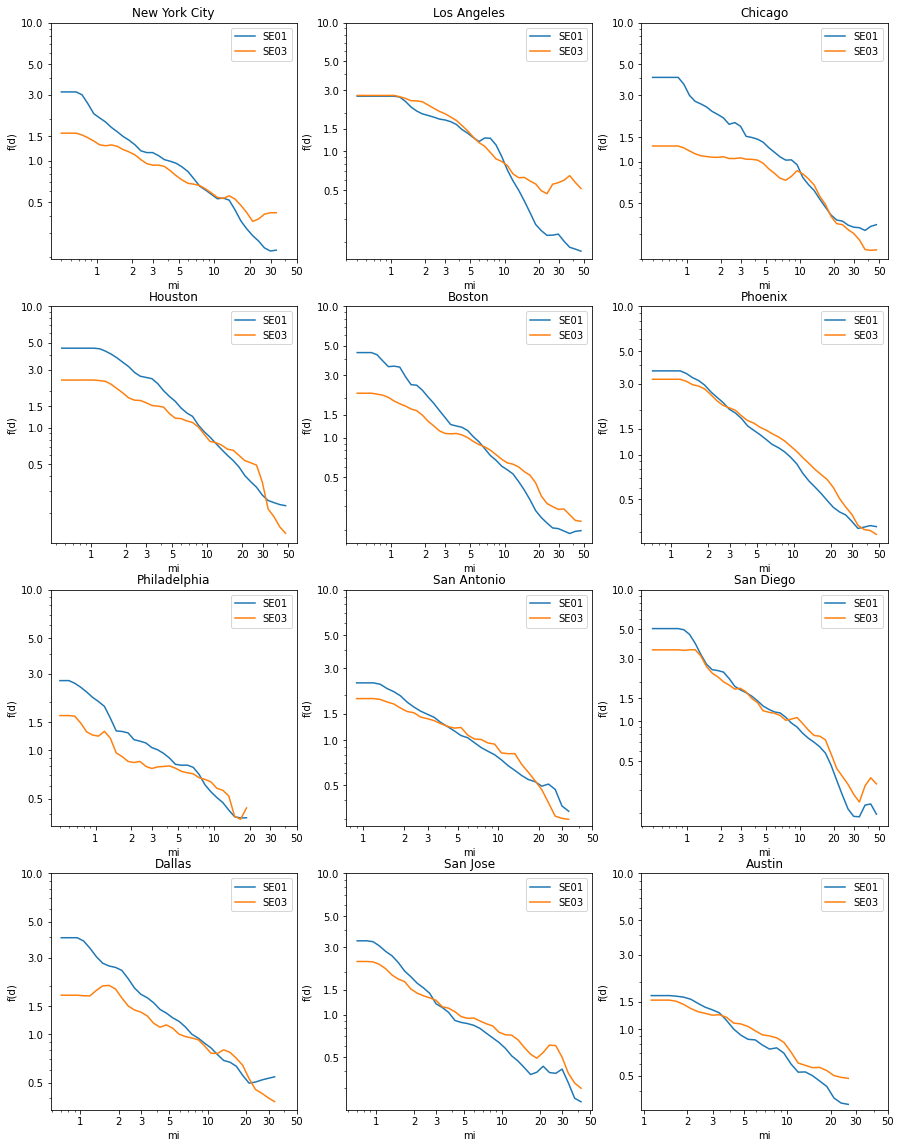

In [75]:
# 0.2% / 2000

fig,ax = plt.subplots(4,3,figsize=(15,20))
i= 0
for city,state, counties in cities:
#     if city in ['Chicago','Phoenix','Houston','San Antonio','Austin', 'San Jose']:
#         pass
#     else:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    df = df.sort_values(by='bin')
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('mi')
    i += 1

# plt.savefig('img/curve.png')